## Data Collection and Feature Engineering steps

In [1]:
from IPython.display import clear_output
!pip install transformers[torch]
clear_output()

In [2]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer

def load_data(data_url):
    return pd.read_csv(data_url, sep='\t')

def preprocess_data(data):
    header = ["comment", "emotion", "id"]
    data.columns = header
    data = data[['comment', 'emotion']]
    data = data[data['emotion'].apply(lambda x: len(x.split(',')) == 1)]
    data['emotion'] = data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)
    return data

def sample_data(data, fraction=0.1):
    return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)

def tokenize_data(comments):
    # Tokenize using the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer(comments, padding=True, truncation=True, return_tensors='pt')

# URLs for train and validation data
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv'
validation_data_url = 'https://github.com/google-research/google-research/raw/master/goemotions/data/dev.tsv'

# Process train data
train_data = load_data(train_data_url)
train_data = preprocess_data(train_data)
sampled_train_data = sample_data(train_data)

# Process validation data
validation_data = load_data(validation_data_url)
validation_data = preprocess_data(validation_data)
sampled_validation_data = sample_data(validation_data)

# Tokenize the comments
train_tokenized_comments = tokenize_data(sampled_train_data['comment'].to_list())
validation_tokenized_comments = tokenize_data(sampled_validation_data['comment'].to_list())

# Prepare training data
X_train = train_tokenized_comments['input_ids']
attention_masks_train = train_tokenized_comments['attention_mask']
y_train = torch.tensor(sampled_train_data['emotion'].values)

# Prepare validation data
X_validation = validation_tokenized_comments['input_ids']
attention_masks_validation = validation_tokenized_comments['attention_mask']
y_validation = torch.tensor(sampled_validation_data['emotion'].values)

# Map the new labels to their original emotion names
emotions_dict = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}

print()
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("y_train unique:", np.unique(y_train))

/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_32180/650025010.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_keys=False).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
/var/folders/xd/gw_pmm5d23s8dm3h09tn28x00000gn/T/ipykernel_32180/650025010.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby('emotion', group_keys


X_train shape: torch.Size([3630, 316])
y_train shape: torch.Size([3630])
y_train unique: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

### Initialization

In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

def print_device_info(device):
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
        print(f"CUDA memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    elif device.type == "mps":
        torch.mps.empty_cache()
        print(f"MPS memory allocated: {torch.mps.current_allocated_memory() / 1e9:.2f} GB")
    elif device.type == "cpu":
        print("No GPU available. Using CPU.")

device = get_device()
print_device_info(device)

Using device: mps
MPS memory allocated: 0.00 GB


### Define the model

In [6]:
from transformers import BertForSequenceClassification
# Load the BERT model
# we will use the bert-base-uncased model
# this model will classify the comments into 10 emotions

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=28)
model.to(device);  # Move the model to the GPU

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

### Defining the emotion dataset

In [8]:
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments


# Create a Dataset class
class EmotionDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

# Prepare datasets
train_dataset = EmotionDataset(X_train, attention_masks_train, y_train)
validation_dataset = EmotionDataset(X_validation, attention_masks_validation, y_validation)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="steps",  # Evaluate every few steps
    eval_steps=10,  # Evaluate every 10 logging steps
    no_cuda=True if device.type != 'cuda' else False,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset
)

# Train the model
trainer.train()

  0%|          | 0/227 [00:00<?, ?it/s]

{'loss': 3.5549, 'grad_norm': 5.9581708908081055, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.04}


  0%|          | 0/29 [00:00<?, ?it/s]

{'eval_loss': 3.5290515422821045, 'eval_runtime': 2.992, 'eval_samples_per_second': 152.07, 'eval_steps_per_second': 9.692, 'epoch': 0.04}


KeyboardInterrupt: 

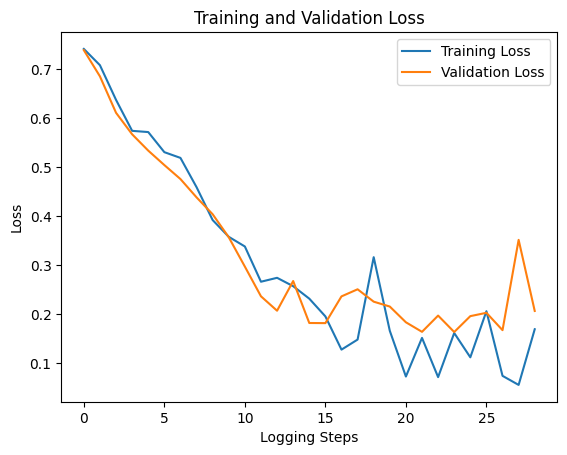

In [ ]:
import matplotlib.pyplot as plt

# Extract loss values from the logs
train_losses = []
eval_losses = []
for log in trainer.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])

# Plot the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Logging Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()